# Classification methods for hypertension prediction

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from itertools import cycle

In [3]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,label_binarize
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc

from sklearn.multiclass import OneVsRestClassifier

### Abstract

This project aims to compare the performance of different methods for supervised machine learning while predicting elevated blood pressure from medical data available in the online community Kaggle. The project consists of two parts which use data from two different datasets containing patient information such as laboratory data and presence or absence of certain medical conditions. The main characteristics of these are summarized and visualised via exploratory data analysis. The data is tidied and prepared for machine learning and feature engineering is also applied. In both notebooks I am using Grid Search with cross-validation to train several different models with different hyperparameters of each of 6 types of machine learning algorithms for classification: Logistic regression, Decision tree, Random forest, Support vector machine and k-nearest neighbors. After that I am plotting learning curves for all models, and choosing one for further analysis, and eventually for further optimisation. I am also plotting a receiver operating characteristic curve (ROC) and confusion matrix for detailed scoring analysis on the chosen model. The final part of the first notebook is hypertension prediction on a small set of unlabelled data. <br>

In the second notebook I am performing similar data examination; however this time I am comparing how the tuned machine learning algorithms are performing on raw data and on data which has been subject of dimensionality reduction in order to evaluate the presence of noise in the data.

### Introduction

Hypertension is a leading, yet controllable risk factor for heart disease, stroke, heart failure, renal disease and recurrent cardiovascular events. Among the risk factors associated with developement of hypertension are: age, sex, family history, smoking habits, alcohol consumption and body-mass index (BMI). Additionally blood pressure is affected by metabolic factors including blood cholesterol, triglycerides, low-density lipoproteins, liver function presented with laboratory reading of hepatic enzymes and others.


Diagnosis of high blood pressure is based on two different guidelines:<br>

1. Classification according to the Seventh Report of the Joint National Committee on Prevention, Detection, Evaluation, and Treatment of High Blood Pressure (2003 Guideline):<br>

| **Normal Blood Pressure**     |  **At Risk** (prehypertension) | **High Blood Pressure (hypertension)** |
|-------------------------------|--------------------------------|----------------------------------------|
| systolic: less than 120 mmHg  | systolic: 120–139 mmHg         | systolic: 140 mmHg or higher           |
| diastolic: less than 80 mmHg  | diastolic: 80–89 mmHg          | diastolic: 90 mmHg or higher           |


2. Classification according to the American College of Cardiology/American Heart Association Guideline for the Prevention, Detection, Evaluation, and Management of High Blood Pressure in Adults (2017 Guideline):<br>

| **Normal Blood Pressure**     |  **Elevated** (prehypertension)  | **High Blood Pressure (hypertension)** |
|-------------------------------|----------------------------------|----------------------------------------|
| systolic: less than 120 mmHg  | systolic: 120–129 mmHg           | systolic: 130 mmHg or higher           |
| diastolic: less than 80 mmHg  | diastolic: less than 80 mmHg     | diastolic: 80 mmHg or higher           |

There are many scientific articles that investigate the opportunity to use machine learning in order to predict hypertension or hypertension outcome based on clinical and personal data. Most of them use artificial neural networks (ANN) for this goal. Some of the investigations such as the one from the Qatar Biobank Study [1] lead to high performance results of the machine learning algorithms used. As clinical data is considered sensitive information it is particluarly difficult to obtain consent or statistics excerpt for non-scientific or educational purposes. 

### Data preprocessing

##### Data desciption 

There are 3 types of input features in the dataset:
   1. Objective: factual information
   2. Examination: results of medical examination
   3. Subjective: information given by the patient.

Features:
   1. Age - Objective Feature - age - int (days)
   2. Height - Objective Feature - height - int (cm) 
   3. Weight - Objective Feature - weight - float (kg) 
   4. Gender - Objective Feature - gender - categorical code
   5. Systolic blood pressure - Examination Feature - ap_hi - int (mmHg)
   6. Diastolic blood pressure - Examination Feature - ap_lo - int (mmHg)
   7. Cholesterol - Examination Feature - cholesterol - 1: normal, 2: above normal, 3: well above normal
   8. Glucose - Examination Feature - gluc - 1: normal, 2: above normal, 3: well above normal
   9. Smoking - Subjective Feature - smoke - binary
   10. Alcohol intake - Subjective Feature - alco - binary
   11. Physical activity - Subjective Feature - active - binary
   12. Presence or absence of cardiovascular disease - cardio - binary

All of the dataset values were collected at the moment of medical examination. 

The cardiovascular data was derived from __[kaggle](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset)__.

In [4]:
#Reading cardiovascular data file
cardio_data = pd.read_csv("data/cardio_train.csv", sep = ";")

###### Becomng acquainted with the data and data tiding

The first thing to do is to get overall information about the data: number of observations, data description, finding and handling missing values, finding duplicate values, identifying closely related features with correlation matrix. Additionally, in order to prepare the data for machine learning algorithms to be used, there are several other steps including removing irrelevant columns, converting age column from days to years, converting values in the gender column from 1 and 2 to 0 and 1, getting indicator (dummy) variables and finally selecting the target column which will be the values for blood pressure converted to three classes according to the classification described above. Normalization of the features should also be performed.

I can take a brief look into the dataset with the .head and .shape attributes and also call the .describe function in order to obtain summary of the data.

In [5]:
cardio_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
cardio_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


In [7]:
cardio_data.shape

(70000, 13)

The next task is to find and replace the missing values in the dataset so that the machine learning models can work.

In [8]:
cardio_data.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

There are no missing values. Additionally. I will search for duplicated entries, although as there are no patient identifiers provided, it is not certain that these are real duplicates. Before that the 'id' column has to be dropped because it does not hold any useful information.

In [9]:
cardio_data.drop(columns = "id", inplace = True)

In [10]:
cardio_data.duplicated().sum()

24

There are 24 duplicated entries that are better to be removed.

In [11]:
cardio_data.drop_duplicates(inplace = True)

Another thing which needs to be checked is the span of the columns containing continuous values and the values in the categorical columns. The description of the dataset shows there are some impossible values including negative readings for blood pressure, as well as weights of as low as 10 kilograms. Upper and lower limits need to be set in order to exclude such outliers that are most probably erroneous entries. In addition, height values are also going to be constrained, because in case of dwarfs or giants, there are additional and irrelevant to this project factors influencing health conditions among these people. It is also necessary to check whether the categories in the categorical columns are correct.

In [12]:
def drop_outliers (df, column, min_val, max_val):
    """ Constrains the entries in the df according to preset min_val and max_val"""
    df = df.drop(df[(df[column] < min_val) | (df[column] > max_val)].index)
    return df

The following information will help with setting the acceptable for the dataset values of the non-categorical values.
Dwarfism is defined as adult height of less than 147 centimetres and giantism - as above 210 centimetres.
Highest blood pressure recorded in an individual was 370/360. Blood pressure can be unmeasurably low, so lower limits can be set something like 60/30 in order to remove at least negative values.
The highest weight in the dataset is 200kg which is ok to remain; however there are weights of less than 20 kg which is impossible for an adult, so a minimum weight of 35 kg will be set.

In [13]:
#setting minimum and maximum acceptable values
cardio_data = drop_outliers(cardio_data, "height", 140, 210)
cardio_data = drop_outliers(cardio_data, "weight", 35, 200)
cardio_data = drop_outliers(cardio_data, "ap_hi", 60, 370)
cardio_data = drop_outliers(cardio_data, "ap_lo", 30, 360)

In [14]:
cardio_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,68593.0,19464.643535,2467.706218,10798.0,17658.0,19701.0,21323.0,23713.0
gender,68593.0,1.348942,0.476639,1.0,1.0,1.0,2.0,2.0
height,68593.0,164.465951,7.802328,140.0,159.0,165.0,170.0,207.0
weight,68593.0,74.132651,14.272555,35.0,65.0,72.0,82.0,200.0
ap_hi,68593.0,126.622833,16.762678,60.0,120.0,120.0,140.0,240.0
ap_lo,68593.0,81.383027,9.686980,30.0,80.0,80.0,90.0,190.0
cholesterol,68593.0,1.365066,0.679254,1.0,1.0,1.0,2.0,3.0
gluc,68593.0,1.226131,0.572118,1.0,1.0,1.0,1.0,3.0
smoke,68593.0,0.088099,0.283441,0.0,0.0,0.0,0.0,1.0
alco,68593.0,0.053694,0.225414,0.0,0.0,0.0,0.0,1.0


In [15]:
cardio_data.shape

(68593, 12)

In [16]:
#check if the categories in the categorical columns are correct
for column in ["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"]:
    print(cardio_data[column].unique())

[2 1]
[1 3 2]
[1 2 3]
[0 1]
[0 1]
[1 0]
[0 1]


In [17]:
#modify gender column
cardio_data.gender = cardio_data.gender.replace([2, 1], [1, 0])

#convert age  in days to age in years
cardio_data.age = cardio_data.age.apply(lambda x: x//365)

In [18]:
cardio_data

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,1,168,62.0,110,80,1,1,0,0,1,0
1,55,0,156,85.0,140,90,3,1,0,0,1,1
2,51,0,165,64.0,130,70,3,1,0,0,0,1
3,48,1,169,82.0,150,100,1,1,0,0,1,1
4,47,0,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,52,1,168,76.0,120,80,1,1,1,0,1,0
69996,61,0,158,126.0,140,90,2,2,0,0,1,1
69997,52,1,183,105.0,180,90,3,1,0,1,0,1
69998,61,0,163,72.0,135,80,1,2,0,0,0,1


###### Data and correlations visualisation

It is a good idea to use boxplots to visualise the span of the continuous values, to see how outliers are distributed and to confirm that the impossible values are removed.

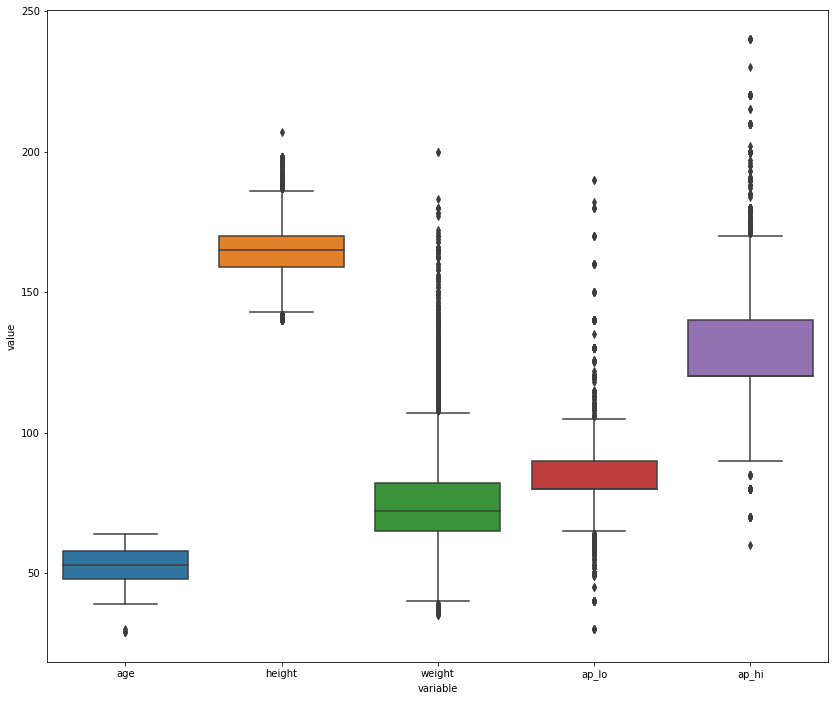

In [19]:
plt.figure(figsize = (14,12))
sns.boxplot(x = "variable", y = "value", data = pd.melt(cardio_data[["age", "height", "weight", "ap_lo", "ap_hi"]]))
plt.show()

The upper outliers for the blood pressure readings are most probably the values of interest. We can see many outliers in the weight data. It is evident from the plot that most people participating in the measurements are adults in their 40s and 50ts, there are also several younger adults. <br>

For the categorical and binary values I am going to use seaborn countplots.

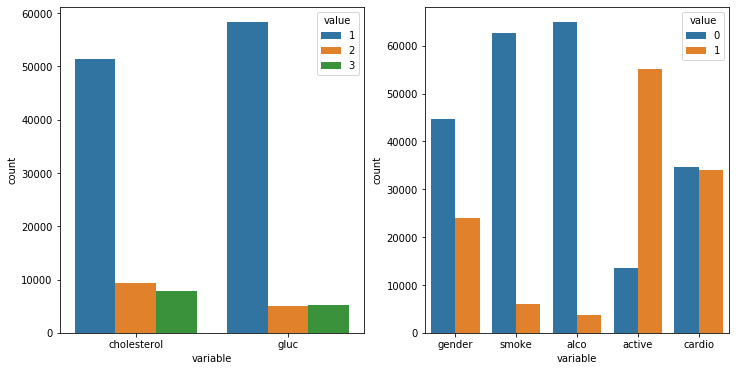

In [20]:
f, ax = plt.subplots(1,2, figsize=(12,6))

sns.countplot(x = "variable", hue = "value", data = pd.melt(cardio_data[["cholesterol", "gluc",]]), ax = ax[0])

sns.countplot(x = "variable", hue = "value", data = pd.melt(cardio_data[["gender",
                                                                         "smoke", "alco", "active", "cardio"]]), ax = ax[1])
plt.show()


The right plot shows that most people in the dataset are male and do not smoke or consume alcohol. The majority of the participants are not active. The presence and absence of cardiological issues are almost equally distributed. According to the left plot most people do have normal cholesterol and glucose blood levels.

Let's now see how the different features are correlated.

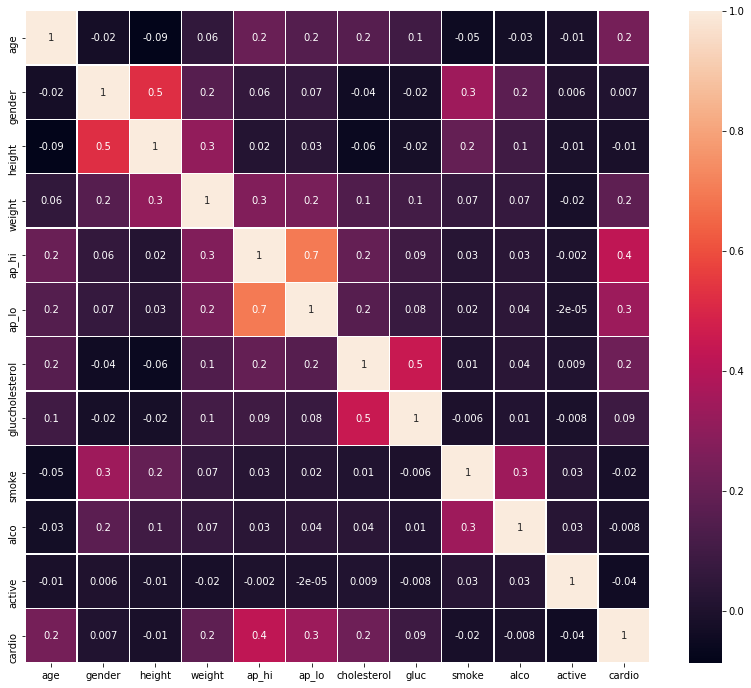

In [21]:
f, ax = plt.subplots(figsize = (14,12))
sns.heatmap(cardio_data.corr(), annot = True, fmt = ".1g", linewidths = 0.5, ax = ax)

#fixing first and last row of the matrix as they are cut in half
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Obviously there is correlation between the low and high blood pressure values which is expected. Additionally there is apparently correlation between values of blood glucose and cholesterol, as well as between height and gender. Some connection between systolic blood pressure readings and cardiological disease is also discernible.

###### Preparing feature and target data for machine learning

If just one of the blood pressure readings (systolic or diastolic) is higher than normal, this is considered prehypertension or hypertension. Because of this, classification of blood pressure can be done based on the sum of both readings. What is more, taking the sum is a way to keep blood pressure values with mistakenly reversed systolic and diastolic readings (diastolic blood pressure cannot be higher than systolic).

In [22]:
#preparing the target column
cardio_data["hypertension"] = cardio_data.ap_hi + cardio_data.ap_lo

conditions = [
    (cardio_data["hypertension"] <= 200),
    (cardio_data["hypertension"] <= 230) & (cardio_data["hypertension"] > 200),
    (cardio_data["hypertension"] > 230)
    ]

# create a list of the values we want to assign for each condition
values = ["normal", "prehypertension", "hypertension"]

# create a new column and use np.select to assign values to it using our lists as arguments
cardio_data["hypertension"] = np.select(conditions, values)

In [23]:
cardio_data = cardio_data.reset_index(drop=True)

In [24]:
cardio_data

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,hypertension
0,50,1,168,62.0,110,80,1,1,0,0,1,0,normal
1,55,0,156,85.0,140,90,3,1,0,0,1,1,prehypertension
2,51,0,165,64.0,130,70,3,1,0,0,0,1,normal
3,48,1,169,82.0,150,100,1,1,0,0,1,1,hypertension
4,47,0,156,56.0,100,60,1,1,0,0,0,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68588,52,1,168,76.0,120,80,1,1,1,0,1,0,normal
68589,61,0,158,126.0,140,90,2,2,0,0,1,1,prehypertension
68590,52,1,183,105.0,180,90,3,1,0,1,0,1,hypertension
68591,61,0,163,72.0,135,80,1,2,0,0,0,1,prehypertension


In [25]:
# Separating features and target data
cardio_data_features = cardio_data.drop(columns=["ap_hi", "ap_lo", "hypertension"])
cardio_data_target = cardio_data["hypertension"]

In [26]:
cardio_data_features

,age,gender,height,weight,cholesterol,gluc,smoke,alco,active,cardio
0,50,1,168,62.0,1,1,0,0,1,0
1,55,0,156,85.0,3,1,0,0,1,1
2,51,0,165,64.0,3,1,0,0,0,1
3,48,1,169,82.0,1,1,0,0,1,1
4,47,0,156,56.0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
68588,52,1,168,76.0,1,1,1,0,1,0
68589,61,0,158,126.0,2,2,0,0,1,1
68590,52,1,183,105.0,3,1,0,1,0,1
68591,61,0,163,72.0,1,2,0,0,0,1


Deriving information and visualising target data is also necessary.

In [28]:
cardio_data_target.unique()

array(['normal', 'prehypertension', 'hypertension'], dtype=object)

In [29]:
cardio_data_target.shape

(68593,)

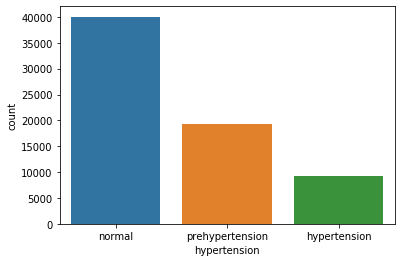

In [30]:
sns.countplot(x = cardio_data_target)
plt.show()

Obviously the three different classes do not have equal counts, so the dataset is imbalanced

Тhe cholesterol and glucose columns are the only categorical columns with more than two categories. Before getting the indicator (dummy) values for these, I am going to give meaningful names for the resulting columns.

In [31]:
cardio_data_features["cholesterol"] = cardio_data_features["cholesterol"].map({ 1: "normal", 2: "above normal", 3: "well above normal"})
cardio_data_features["gluc"] = cardio_data_features["gluc"].map({ 1: "normal", 2: "above normal", 3: "well above normal"})

In [32]:
cardio_data_features = pd.get_dummies(cardio_data_features, columns=["cholesterol", "gluc"])

In [33]:
cardio_data_features

,age,gender,height,weight,smoke,alco,active,cardio,cholesterol_above normal,cholesterol_normal,cholesterol_well above normal,gluc_above normal,gluc_normal,gluc_well above normal
0,50,1,168,62.0,0,0,1,0,0,1,0,0,1,0
1,55,0,156,85.0,0,0,1,1,0,0,1,0,1,0
2,51,0,165,64.0,0,0,0,1,0,0,1,0,1,0
3,48,1,169,82.0,0,0,1,1,0,1,0,0,1,0
4,47,0,156,56.0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68588,52,1,168,76.0,1,0,1,0,0,1,0,0,1,0
68589,61,0,158,126.0,0,0,1,1,1,0,0,1,0,0
68590,52,1,183,105.0,0,1,0,1,0,0,1,0,1,0
68591,61,0,163,72.0,0,0,0,1,0,1,0,1,0,0


I can aslo remove the dummy columns that can be deduced from the others - cholesterol_normal and gluc_normal

In [34]:
cardio_data_features.drop(columns = ["cholesterol_normal", "gluc_normal"], inplace = True)

Finally, it is always a good idea to normalize the features data, although the ranges of the numeric columns in this dataset are not so different. 

In [35]:
scaler = StandardScaler()
cardio_data_features[["age", "height", "weight"]] = scaler.fit_transform(cardio_data_features[["age", "height", "weight"]])

In [36]:
cardio_data_features

,age,gender,height,weight,smoke,alco,active,cardio,cholesterol_above normal,cholesterol_well above normal,gluc_above normal,gluc_well above normal
0,-0.417987,1,0.452951,-0.850075,0,0,1,0,0,0,0,0
1,0.320785,0,-1.085062,0.761421,0,0,1,1,0,1,0,0
2,-0.270233,0,0.068448,-0.709945,0,0,0,1,0,1,0,0
3,-0.713496,1,0.581119,0.551226,0,0,1,1,0,0,0,0
4,-0.861250,0,-1.085062,-1.270465,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
68588,-0.122478,1,0.452951,0.130836,1,0,1,0,0,0,0,0
68589,1.207311,0,-0.828727,3.634088,0,0,1,1,1,0,1,0
68590,-0.122478,1,2.375468,2.162722,0,1,0,1,0,1,0,0
68591,1.207311,0,-0.187888,-0.149424,0,0,0,1,0,0,1,0


###### Polynomial features

Additionally, as the features are not too many, I will check if interaction between the data features is going to change the performance of the machine learning methods. In order to do that, I will use the polynomial features transformer of second degree which will generate a new feature matrix consisting of all polynomial combinations of the features. 

In [37]:
poly_transformer = PolynomialFeatures(degree = 2, interaction_only = True)

In [38]:
cardio_features_polynomial = poly_transformer.fit_transform(cardio_data_features)

In [39]:
cardio_features_polynomial.shape

(68593, 79)

### Machine learning methods exploration

###### Data splitting and interaction

The idea is first to split the data to test and train sets, and after that - to create a stratified k-fold split object so it can be used later for cross-validation. I am going to make a standard split with 80% train data as there are enough observations for the remaining test data. The data target is imbalanced and I am going to use it for stratified split.

In [40]:
cardio_features_train, cardio_features_test, cardio_target_train, cardio_target_test = train_test_split(
    cardio_data_features, cardio_data_target, train_size = 0.8, stratify = cardio_data_target)

In [41]:
cardio_features_train.shape

(54874, 12)

In [42]:
cardio_features_test.shape

(13719, 12)

Next I will split the data with polynomial features.

In [43]:
cardio_features_polynomial_train, cardio_features_polynomial_test, cardio_target_polynomial_train, cardio_target_polynomial_test = train_test_split(
    cardio_features_polynomial, cardio_data_target, train_size = 0.8, stratify = cardio_data_target)

In [44]:
cardio_features_polynomial_train.shape

(54874, 79)

In [45]:
k_fold =  StratifiedKFold(n_splits = 5)

###### Fit and score function

I am going to define a function which will first perform grid search with predefined hyperparameters, using f1-scoring, which is weighted so it can fit for multiclass classification. Then the function will fit with the training data using the grid and select the best classifier depending on the validation results. After that the best classifier will be used to predict the testing data and compare the results to the testing target. The function will also print the cross-validation results. Finally, it will print all scoring results with the given method name.

In [46]:
def train_score_model (model, parameters, model_name, features_train, features_test, target_train, target_test):
    """Fit model with selected parameters on train data, 
    score the performance and print cv and scoring results. Returns best classifier"""

    grid = GridSearchCV(model, param_grid = parameters, cv = k_fold, scoring = "f1_weighted")
    
    grid_search = grid.fit(features_train, target_train)
    print(grid_search.cv_results_)
    
    best_classifier = grid_search.best_estimator_
        
    print("{0} best score is {1}".format(model_name, grid_search.best_score_))
    
    test_classifier_score = f1_score(target_test, best_classifier.predict(features_test), average = "weighted")
    print("For {0} the f1 score for the test data is {1}".format(model_name, test_classifier_score))
        
    return  best_classifier

###### Logistic Regression

First machine learning method to train and test will be Logistic Regression.

In [47]:
logistic_regression_model = LogisticRegression(multi_class = "ovr", solver = "liblinear")

I am going to use a grid with different values for three hyperparameters: penalty, regularisation parameter C, and maximum number of iterations before convergence. As a penalty parameter I am going to let the method choose between l1 and l2 regularisation that both shrink the regression coefficients in order to reduce overfitting. The key difference between the two is that l1 shrinks the coefficients of the less important feature, setting some of them to zero which means it removes them. Additionally regularisation will be tuned with several different C (inverse of regularization strength) values. I am also going to allow for more than the default iterations until convergence with setting the parameter of max_iter. After that I will select the best estimator, i.e. the classifier with those parameters that gives the best f1 score. F score is the preferred metric as the three classes are not with evenly distributed values and the default accuracy score is not going to work.

In [48]:
regression_parameters = {
    "penalty": ["l1", "l2"],
    "C": [1e-3, 1e-1, 1, 100, 1e6],
    "max_iter": [100, 200, 500],
}

In [49]:
# train and score the LR model with the raw data
logistic_best = train_score_model (logistic_regression_model, regression_parameters, "logistic regression", cardio_features_train, cardio_features_test, cardio_target_train, cardio_target_test)

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sk

{'mean_fit_time': array([0.26887212, 0.36246147, 0.26840396, 0.34496489, 0.26524305,
       0.35364938, 0.42721009, 0.44102273, 0.45637569, 0.44152508,
       0.44446392, 0.43798518, 0.45526824, 0.4420435 , 0.46544013,
       0.46626763, 0.45272374, 0.37245464, 0.42581544, 0.37407846,
       0.43805156, 0.44224505, 0.45419536, 0.41912646, 0.44714656,
       0.41956892, 0.42530918, 0.35855837, 0.41107378, 0.35831289]), 'std_fit_time': array([0.01054218, 0.01592035, 0.00918106, 0.00581157, 0.00989853,
       0.0160566 , 0.00902973, 0.00637322, 0.02611309, 0.0107683 ,
       0.01538384, 0.00592044, 0.0118476 , 0.01899463, 0.01962883,
       0.04143031, 0.00969542, 0.0242888 , 0.01631414, 0.026939  ,
       0.01693164, 0.02833135, 0.01130579, 0.0142872 , 0.0072214 ,
       0.00597947, 0.02298101, 0.00851592, 0.01647123, 0.01135016]), 'mean_score_time': array([0.10733738, 0.10514445, 0.0958581 , 0.094032  , 0.10212932,
       0.10061078, 0.09525266, 0.10059948, 0.09408822, 0.09865537,
     

The best validation score of 57% that the LR achieves with the raw data is low and the test score is marginally higher. At least the model seems to not overfit the data. I am now going to train the models on the polynomial features data. Another thing that the cross-validation data shows is that there is no much difference in the validation scores of the different training subsets which means that the model is stable.

In [50]:
#train and score the polynomial data
poly_logistic_best = train_score_model (logistic_regression_model, regression_parameters, "logistic regression", cardio_features_polynomial_train, cardio_features_polynomial_test, cardio_target_polynomial_train, cardio_target_polynomial_test)

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sk

{'mean_fit_time': array([0.3377459 , 0.81180167, 0.32648349, 0.8006155 , 0.34005871,
       0.80224261, 2.31332588, 1.84991598, 2.28016262, 1.80986176,
       2.18996449, 1.78215709, 2.7635366 , 2.13878942, 2.77450104,
       2.13467531, 2.81382532, 2.14460254, 2.90164042, 2.27325783,
       3.26551957, 2.27015071, 3.40985155, 2.32418041, 3.15278387,
       2.25958786, 3.23544755, 2.24512863, 3.07205591, 2.25288348]), 'std_fit_time': array([0.01382966, 0.00925245, 0.01148873, 0.00704248, 0.01238484,
       0.00510546, 0.11969049, 0.04718398, 0.05678964, 0.0160819 ,
       0.14193939, 0.03783596, 0.12140145, 0.09177154, 0.06522928,
       0.08576198, 0.1215641 , 0.06935786, 0.08827904, 0.06366138,
       0.22851828, 0.08442075, 0.33976712, 0.05991877, 0.17658374,
       0.09837212, 0.19997414, 0.08344061, 0.21048567, 0.09883746]), 'mean_score_time': array([0.0839241 , 0.08440132, 0.08629537, 0.08460217, 0.08217607,
       0.08590207, 0.09239769, 0.08859458, 0.0828599 , 0.08464022,
     

The best validation score and the test score show slight improvement to 58%

###### Decision Tree

The second method to train and test is Decision Tree classifier. I am going to use a grid for cross-validation setting maximum depth of the tree (which will constrain the tree to not expand too much, i.e. until there is one sample per leaf), criterion for information gain and maximum samples per the final nodes.

In [51]:
tree_model = DecisionTreeClassifier()

In [52]:
parameters_tree = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 6, 12, 14, 20],
    "min_samples_leaf": [2, 5, 8, 12],
}

In [53]:
#train and score on the raw data
tree_best = train_score_model (tree_model, parameters_tree, "Decision Tree", cardio_features_train, cardio_features_test, cardio_target_train, cardio_target_test)

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sk

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'mean_fit_time': array([0.11710949, 0.10931611, 0.11528273, 0.1137691 , 0.13366003,
       0.13236985, 0.13112254, 0.13212833, 0.17002225, 0.17215405,
       0.17614174, 0.1782876 , 0.1908318 , 0.18657866, 0.19337893,
       0.17365394, 0.20971937, 0.20041361, 0.18511162, 0.19706402,
       0.11233268, 0.11611137, 0.11550784, 0.10848022, 0.13225894,
       0.13158331, 0.16028662, 0.1335669 , 0.19119697, 0.16869707,
       0.1770432 , 0.19598937, 0.19752169, 0.18013659, 0.17695556,
       0.17549667, 0.216362  , 0.20157065, 0.19085383, 0.18580418]), 'std_fit_time': array([0.00876211, 0.00231822, 0.00729742, 0.00703999, 0.00668169,
       0.01066126, 0.00410137, 0.01128433, 0.00611788, 0.00526597,
       0.00735917, 0.01077322, 0.02167696, 0.01306425, 0.01946708,
       0.00704076, 0.01608922, 0.01627151, 0.00172788, 0.01234629,
       0.00470553, 0.01767395, 0.00599571, 0.0045289 , 0.00313288,
       0.00426317, 0.04723788, 0.00723637, 0.01588288, 0.00123852,
       0.00598942, 0.04339

In [54]:
#train and score on the polynomial features data
tree_best_poly = train_score_model (tree_model, parameters_tree, "Decision Tree", cardio_features_polynomial_train, cardio_features_polynomial_test, cardio_target_polynomial_train, cardio_target_polynomial_test)

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sk

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sk

{'mean_fit_time': array([0.27971139, 0.280509  , 0.28410306, 0.27972493, 0.41225615,
       0.40744476, 0.41972876, 0.40984573, 0.61987033, 0.65052786,
       0.62674875, 0.6123786 , 0.74866233, 0.67827401, 0.62541823,
       0.65814147, 0.90744357, 0.82243109, 0.79914689, 0.82378516,
       0.32421975, 0.30375957, 0.29082961, 0.28986812, 0.43311715,
       0.42198448, 0.42673531, 0.42870178, 0.68509116, 0.66016984,
       0.65993919, 0.64995346, 0.75672131, 0.73595014, 0.7269918 ,
       0.71287804, 0.93345504, 0.88912334, 0.84215603, 0.80331373]), 'std_fit_time': array([0.00243505, 0.00260398, 0.00845349, 0.00252622, 0.00254563,
       0.00601142, 0.01263937, 0.00468988, 0.00617263, 0.03533395,
       0.04028696, 0.00745212, 0.03440299, 0.03883664, 0.01024089,
       0.04584801, 0.04440861, 0.01789214, 0.01900477, 0.0391893 ,
       0.01981768, 0.02168746, 0.00304103, 0.00668613, 0.00635475,
       0.00408682, 0.00496878, 0.00783886, 0.00456882, 0.0051998 ,
       0.01089506, 0.00676

Decision Tree algorithm gives almost equal results for the raw and for the polynomial features data. The scores are marginally better from those, provided by the Logistic Regression method. However, Decision Tree algorithm requires less computation time.

###### Random forest

I am also going to score some ensemble methods to see if they perform better than the single tree. First comes the Random Forest classifier. As the models require more computation time, I am going to use only number of estimators for the grid search. I am also going to set the minimum samples per leaf to two instead of the default 1, in order to prevent overfitting as much as possible.

In [55]:
forest_model = RandomForestClassifier(min_samples_leaf = 2)

In [56]:
parameters_forest = {
    "n_estimators": [100, 200, 500],
}

In [57]:
#train and score on the raw data
forest_best = train_score_model(forest_model, parameters_forest, "Random Forest", cardio_features_train, cardio_features_test, cardio_target_train, cardio_target_test)

{'mean_fit_time': array([ 3.41251397,  6.88165927, 16.76416678]), 'std_fit_time': array([0.02838603, 0.12079321, 0.04909416]), 'mean_score_time': array([0.36076069, 0.65318742, 1.5164885 ]), 'std_score_time': array([0.00509608, 0.02981716, 0.01742524]), 'param_n_estimators': masked_array(data=[100, 200, 500],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.58467218, 0.58156792, 0.58504145]), 'split1_test_score': array([0.58586608, 0.58707218, 0.58675872]), 'split2_test_score': array([0.58202544, 0.58118336, 0.5807809 ]), 'split3_test_score': array([0.58538309, 0.58515533, 0.58550722]), 'split4_test_score': array([0.58875301, 0.58623294, 0.58406456]), 'mean_test_score': array([0.5853399 , 0.58424231, 0.58443058]), 'std_test_score': array([0.00216143, 0.00242133, 0.00202025]), 'rank_test_score': array([1, 3, 2])}
Random Forest best scor

In [58]:
#train and score on the polynomial features data
forest_best_poly = train_score_model(forest_model, parameters_forest, "Random Forest", cardio_features_polynomial_train, cardio_features_polynomial_test, cardio_target_polynomial_train, cardio_target_polynomial_test)

{'mean_fit_time': array([ 8.00836854, 15.77339859, 40.17231388]), 'std_fit_time': array([0.18613481, 0.06148505, 1.65422204]), 'mean_score_time': array([0.3960464 , 0.72605543, 1.71786356]), 'std_score_time': array([0.00404811, 0.01275807, 0.05076764]), 'param_n_estimators': masked_array(data=[100, 200, 500],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.57939069, 0.58151193, 0.58141827]), 'split1_test_score': array([0.5781696 , 0.5787186 , 0.57909359]), 'split2_test_score': array([0.58994982, 0.58983756, 0.59076096]), 'split3_test_score': array([0.58653565, 0.58248525, 0.58350929]), 'split4_test_score': array([0.58560839, 0.58737713, 0.5858116 ]), 'mean_test_score': array([0.5839308 , 0.58398603, 0.58411871]), 'std_test_score': array([0.00446394, 0.00404623, 0.00399755]), 'rank_test_score': array([3, 2, 1])}
Random Forest best scor

Again we can see results similar to those of the prior two methods.

###### AdaBoost
I am also going to try another ensemble method which implies boosting. As a base estimator for this algorithm, I'll be using the default tree classifier. For grid search I am going to choose between different number of estimators, which is the most important hyperparameter here, and also a difference in the learning rate. What the learning rate does is when lowered - to minimise the influence of each of the weak estimators on the weights of the model, so it is partially compensated by the number of estimators.

In [59]:
boost_model = AdaBoostClassifier()

In [60]:
parameters_boost = {
    "n_estimators": [25, 50, 100],
    "learning_rate": [0.05, 0.1, 1],
}

In [61]:
#train and score on the raw data
boost_best = train_score_model(boost_model, parameters_boost, "AdaBoost", cardio_features_train, cardio_features_test, cardio_target_train, cardio_target_test)

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sk

{'mean_fit_time': array([ 2.53082666,  5.03455992, 10.09825883,  2.55396681,  5.68033643,
       10.08248072,  2.49493809,  4.9671031 , 10.00983605]), 'std_fit_time': array([0.02927532, 0.04292738, 0.13870965, 0.03291919, 0.52921609,
       0.1361705 , 0.01005711, 0.0338094 , 0.07318368]), 'mean_score_time': array([0.10911369, 0.14341946, 0.20683517, 0.11409535, 0.15000162,
       0.20504236, 0.10731244, 0.13842902, 0.20387449]), 'std_score_time': array([0.00185082, 0.00311921, 0.00288798, 0.00906843, 0.01029466,
       0.00146634, 0.00149558, 0.00230806, 0.00232857]), 'param_learning_rate': masked_array(data=[0.05, 0.05, 0.05, 0.1, 0.1, 0.1, 1, 1, 1],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[25, 50, 100, 25, 50, 100, 25, 50, 100],
             mask=[False, False, False, False, False, False, False, False,
                   False],
    

In [62]:
#train and score on the polynomial features data
boost_best_poly = train_score_model (boost_model, parameters_boost, "AdaBoost", cardio_features_polynomial_train, cardio_features_polynomial_test, cardio_target_polynomial_train, cardio_target_polynomial_test)

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sk

{'mean_fit_time': array([ 4.53018489,  8.96368089, 17.84657741,  4.48902159,  8.94159765,
       17.79295545,  4.45688238,  8.96079602, 18.13556137]), 'std_fit_time': array([0.04809815, 0.05330648, 0.09148306, 0.01569991, 0.02299225,
       0.06571639, 0.03531599, 0.12641803, 0.55492329]), 'mean_score_time': array([0.17052555, 0.26229734, 0.44823327, 0.16835394, 0.25693612,
       0.4475832 , 0.16774282, 0.26009493, 0.46397066]), 'std_score_time': array([0.00491616, 0.00295415, 0.00763237, 0.00145503, 0.0029938 ,
       0.00640982, 0.00115143, 0.00194887, 0.0279093 ]), 'param_learning_rate': masked_array(data=[0.05, 0.05, 0.05, 0.1, 0.1, 0.1, 1, 1, 1],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[25, 50, 100, 25, 50, 100, 25, 50, 100],
             mask=[False, False, False, False, False, False, False, False,
                   False],
    

Again the same scores can be seen, it seems that this is the maximum score that can be achieved with this data. The best model is the one with the default learning rate, and number of estimators 100 (default is 50). More estimators give better result.

###### Support vector machines

Now I am going to train different SVM models. I am going to use linear Kernel because, although I have a non-linear separation problem, the model with the default Gaussian Kernel and the polynomial Kernel is running extremely slow. Increasing the number of iterations does not help with convergence, so I will leave the default value. During cross-validation I am going to try different regularisations with different values of the penalty parameter 'C'.

In [63]:
svm_model = LinearSVC()

In [64]:
parameters_svm = {
    "C": [0.1, 1, 10],
}

In [65]:
#train and score on the raw data
svm_best = train_score_model (svm_model, parameters_svm, "SVM", cardio_features_train, cardio_features_test, cardio_target_train, cardio_target_test)

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sk

{'mean_fit_time': array([ 2.6447433 , 14.98678727, 15.64686227]), 'std_fit_time': array([0.05726531, 0.08834296, 0.09281711]), 'mean_score_time': array([0.08256135, 0.08656669, 0.08375096]), 'std_score_time': array([0.0061176 , 0.00674125, 0.00341494]), 'param_C': masked_array(data=[0.1, 1, 10],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}], 'split0_test_score': array([0.56503347, 0.56496489, 0.5647435 ]), 'split1_test_score': array([0.56756693, 0.5676056 , 0.56757579]), 'split2_test_score': array([0.56164286, 0.56173278, 0.56199429]), 'split3_test_score': array([0.56679859, 0.56670144, 0.56680566]), 'split4_test_score': array([0.56531385, 0.56538228, 0.56608194]), 'mean_test_score': array([0.56527114, 0.5652774 , 0.56544022]), 'std_test_score': array([0.00204092, 0.00200608, 0.00195944]), 'rank_test_score': array([3, 2, 1])}
SVM best score is 0.5654402248200302
For SVM the f1 score for the test da

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [66]:
#train and score on the polynomial features data
svm_best_poly = train_score_model (svm_model, parameters_svm, "SVM", cardio_features_polynomial_train, cardio_features_polynomial_test, cardio_target_polynomial_train, cardio_target_polynomial_test)

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

{'mean_fit_time': array([27.71021085, 25.05647345, 25.12299151]), 'std_fit_time': array([0.76059769, 0.06315651, 0.06248127]), 'mean_score_time': array([0.07636375, 0.07037067, 0.07156858]), 'std_score_time': array([0.00703699, 0.00048678, 0.00132272]), 'param_C': masked_array(data=[0.1, 1, 10],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}], 'split0_test_score': array([0.58089861, 0.58038284, 0.57467325]), 'split1_test_score': array([0.57829023, 0.57885333, 0.57919428]), 'split2_test_score': array([0.58513189, 0.58443277, 0.57432656]), 'split3_test_score': array([0.58499867, 0.58517554, 0.5862883 ]), 'split4_test_score': array([0.57784625, 0.57755094, 0.57314953]), 'mean_test_score': array([0.58143319, 0.58127915, 0.57752647]), 'std_test_score': array([0.00314397, 0.00302372, 0.0048392 ]), 'rank_test_score': array([1, 2, 3])}
SVM best score is 0.5814331935008765
For SVM the f1 score for the test da

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM gives lower score for the row data and scores similarly to LR on the polynomial features data.

###### K-nearest neighbors classifier

As a last method to evaluate I will use the simple k-nearest neighbors (kNN) algorithm. I will only change the number of neighbors during cross-validation. A large number of neighbors will probably lead to higher bias. The dataset has three classes which means that I can use even numbers for number of neighbors.

In [67]:
knn_model = KNeighborsClassifier()

In [68]:
parameters_knn = {
    "n_neighbors": [3, 5, 8]
}

In [69]:
#train and score on the raw data
knn_best = train_score_model (knn_model, parameters_knn, "kNN", cardio_features_train, cardio_features_test, cardio_target_train, cardio_target_test)

{'mean_fit_time': array([0.11868162, 0.11220798, 0.11509352]), 'std_fit_time': array([0.00327832, 0.00466415, 0.00101781]), 'mean_score_time': array([0.82279038, 0.91458364, 1.06754031]), 'std_score_time': array([0.04633568, 0.01016585, 0.01067766]), 'param_n_neighbors': masked_array(data=[3, 5, 8],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 3}, {'n_neighbors': 5}, {'n_neighbors': 8}], 'split0_test_score': array([0.54707671, 0.55753993, 0.57288792]), 'split1_test_score': array([0.55567239, 0.56331539, 0.57656653]), 'split2_test_score': array([0.55185784, 0.56077514, 0.57065621]), 'split3_test_score': array([0.55644775, 0.5569761 , 0.57230455]), 'split4_test_score': array([0.55657099, 0.55553358, 0.56674329]), 'mean_test_score': array([0.55352508, 0.55882809, 0.57183179]), 'std_test_score': array([0.00365491, 0.00282381, 0.00319468]), 'rank_test_score': array([3, 2, 1])}
kNN best score is 0.5718317925745481
For k

In [70]:
#train and score on the polynomial features data
knn_best_poly = train_score_model (knn_model, parameters_knn, "kNN", cardio_features_polynomial_train, cardio_features_polynomial_test, cardio_target_polynomial_train, cardio_target_polynomial_test)

{'mean_fit_time': array([0.31596189, 0.30777516, 0.3123343 ]), 'std_fit_time': array([0.00892079, 0.0061666 , 0.00657678]), 'mean_score_time': array([4.81274443, 6.18328032, 7.78872108]), 'std_score_time': array([0.11896273, 0.08867876, 0.16643202]), 'param_n_neighbors': masked_array(data=[3, 5, 8],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 3}, {'n_neighbors': 5}, {'n_neighbors': 8}], 'split0_test_score': array([0.55185774, 0.55647524, 0.5659884 ]), 'split1_test_score': array([0.55465649, 0.55342935, 0.56362221]), 'split2_test_score': array([0.55920803, 0.56688608, 0.57179679]), 'split3_test_score': array([0.556308  , 0.55943993, 0.57466292]), 'split4_test_score': array([0.55867872, 0.56153248, 0.56956476]), 'mean_test_score': array([0.55614175, 0.55955258, 0.56912701]), 'std_test_score': array([0.00269906, 0.00457556, 0.00395274]), 'rank_test_score': array([3, 2, 1])}
kNN best score is 0.5691270095534656
For k

KNN is fast with regard to computation time; however, the scores are somehow lower.
It looks like all algorithms give similar results when they are scored on the different folds, so the algorithms are stable. The performance is comparable among all of the methods and the scores are low, however this is probably the best for the data and I am going to do some further analysis using the best estimator from the Random Forest classifiers. 

### Further work with the chosen algorithm

All methods give fairly low, but comparable scores. I am going to further investigate the Random Forest method behaviour with the available data. First I will map the feature importances for the original number of features. Next I will use the best Random Forest estimator to create a confusion matrix providing additional scores. As there are no huge differences between the scores for normal and polynomial data, I will use the normal data which will require less computationl time.

In [71]:
forest_best.fit(cardio_data_features, cardio_data_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [72]:
importances = forest_best.feature_importances_
features = list(cardio_data_features.columns)
zipped = list(zip(features, importances))

pd.DataFrame(zipped, columns = ["features", "importances"])

,features,importances
0,age,0.212045
1,gender,0.014416
2,height,0.230038
3,weight,0.272841
4,smoke,0.009601
5,alco,0.007734
6,active,0.016544
7,cardio,0.178683
8,cholesterol_above normal,0.013893
9,cholesterol_well above normal,0.025496


According to the Random Forest classifier, the most important features are age, height and weight. After that is the presence of cardiological disease. High cholesterol and smoking are also somehow important.

###### Confusion Matrix

In [73]:
forest_best.fit(cardio_features_train, cardio_target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [74]:
predicted = forest_best.predict(cardio_features_test)

In [75]:
#creating confusion matrix with labels set so that the classes correspond
confusion_matrix = confusion_matrix(cardio_target_test, predicted, labels = ["normal", "prehypertension", "hypertension"])

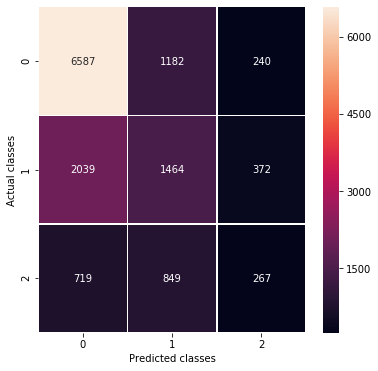

In [76]:
f, ax = plt.subplots(figsize=(6,6))
sns.heatmap(confusion_matrix, fmt = ".0f", annot = True, linewidths = 0.5, ax = ax)

plt.xlabel("Predicted classes")
plt.ylabel("Actual classes")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In order to calculate and compare the classification scores, I have to first calculate the true positive results (tp), true negative results (tn), false positive results (fp) and false negative results (fn) for each of the three classes.
After that, I am going to define a function that calculates the f1-score from the other scores and returns a dataframe with all calculated scores. This can also be achieved by printing the classification report, which I will leave for the second part.

In [77]:
#values for normal blood pressure (class 0)
tn_normal = confusion_matrix[1,1] + confusion_matrix[1,2] + confusion_matrix[2,1] + confusion_matrix[2,2]
tp_normal = confusion_matrix[0,0]
fp_normal = confusion_matrix[1,0] + confusion_matrix[2,0]
fn_normal = confusion_matrix[0,1] + confusion_matrix[0,2]

#values for prehypertension (class 1)
tn_preh = confusion_matrix[0,0] + confusion_matrix[0,2] + confusion_matrix[2,0] + confusion_matrix[2,2]
tp_preh = confusion_matrix[1,1]
fp_preh = confusion_matrix[0,1] + confusion_matrix[2,1]
fn_preh = confusion_matrix[1,0] + confusion_matrix[1,2]

#values for hypertension (class 2)
tn_hyp = confusion_matrix[0,0] + confusion_matrix[0,1] + confusion_matrix[1,0] + confusion_matrix[1,1]
tp_hyp = confusion_matrix[2,2]
fp_hyp = confusion_matrix[0,2] + confusion_matrix[1,2]
fn_hyp = confusion_matrix[2,0] + confusion_matrix[2,1]

In [78]:
def f1_scores_dataframe (accuracy, precision, recall):
    """Calculates the f1 score and creates a dataframe with all scores"""
    f1_score = 2*(recall * precision) / (recall + precision)
    df = pd.DataFrame([[accuracy, precision, recall, f1_score]], columns = ["Accuracy", "Precision", "Recall", "F1 Score"], index = ["Results"])
    return df

In [79]:
#scores for normal blood pressure (class 0)
accuracy = (tp_normal + tn_normal)/(tp_normal + tn_normal + fp_normal + fn_normal)
precision = tp_normal/(tp_normal + fp_normal)
recall = tp_normal/(tp_normal + fn_normal)
f1_scores_dataframe (accuracy, precision, recall)

,Accuracy,Precision,Recall,F1 Score
Results,0.695313,0.704869,0.82245,0.759133


In [80]:
#scores for prehypertension (class 1)
accuracy = (tp_preh + tn_preh)/(tp_preh + tn_preh + fp_preh + fn_preh)
precision = tp_preh/(tp_preh + fp_preh)
recall = tp_preh/(tp_preh + fn_preh)
f1_scores_dataframe (accuracy, precision, recall)

,Accuracy,Precision,Recall,F1 Score
Results,0.676215,0.418884,0.377806,0.397286


In [81]:
#scores for hypertension (class 2)
accuracy = (tp_hyp + tn_hyp)/(tp_hyp + tn_hyp + fp_hyp + fn_hyp)
precision = tp_hyp/(tp_hyp + fp_hyp)
recall = tp_hyp/(tp_hyp + fn_hyp)
f1_scores_dataframe (accuracy, precision, recall)

,Accuracy,Precision,Recall,F1 Score
Results,0.841096,0.303754,0.145504,0.196758


##### Result interpretation

The Random Forest classifier achieves best of the relevant scores (recall, precision and f1-score) for the first class which is the class of normal blood pressure. The results for prehypertension and especially for the hypertension classes are significantly lower. It seems that it is difficult for the method to distinguish between the medical data for pre- and hypertensive patients. It may also be deduced from the numbers in the confusion matrix that the model was misled from features implying borderline values of high blood pressure. The recall score which is important because it shows how many of the results of interest the method guesses, is the lowest score for the third class (hypertension), which is not very good.

### ROC Curve

Receiver Operating Characteristics (ROC) curve is a probability evaluation metric that reflects the performance of binary  classification problems. It can also work for multiclass classification problems; however, a methodology of one versus the rest (OVR) or one versus one (OVO) should be used in this case. As I am working with three classes I am going to first binarize the target column so it transforms to an array of three values of 0 and 1 for each observation.

In [82]:
#Binarize the output
cardio_target_train_binary = label_binarize(cardio_target_train, classes = ["normal", "prehypertension", "hypertension"])
cardio_target_test_binary = label_binarize(cardio_target_test, classes = ["normal", "prehypertension", "hypertension"])

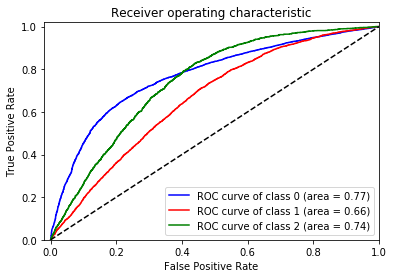

In [83]:
classifier = OneVsRestClassifier(forest_best)
y_score = classifier.fit(cardio_features_train, cardio_target_train_binary).predict_proba(cardio_features_test)


#Code for the ROC curve was taken from stack overflow [12]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(cardio_target_test_binary[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(["blue", "red", "green"])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color = color,
             label = "ROC curve of class {0} (area = {1:0.2f})"
             "".format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc = "lower right")
plt.show()

###### Result interpretation
The ROC curve again shows best performance of the model in distinguishing between class 0 (normal blood pressure) and the other two classes. This is apparent from the fact that the curve for class 0 climbs faster and the area under the curve (AUC) is largest. The AUC for the second class (prehypertension) is smallest, and this is the class with values varying within narrower limits. 

###### Learning curve

Learning curve, when plotting some of the metrics against the number of observations, is a graphical representation of how a machine learning algorithm is becoming better with time, in other words - how or will adding more observations to the data help the model to improve. It is also a good tool to investigate the model’s bias and variance.

In [84]:
def plot_train_curve(model, name, train_sizes):
    """Plots a learning curve for the model."""

        
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator = model,
    X = cardio_data_features,
    y = cardio_data_target, train_sizes = train_sizes, cv = 5, shuffle = True, scoring = 'f1_weighted')
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(validation_scores, axis=1)
    val_std = np.std(validation_scores, axis=1)
    
    plt.figure(figsize = (5,5))
    plt.plot(train_sizes, train_mean, '--', color = "#9fe339",  label = "Training score")
    plt.plot(train_sizes, val_mean, color = "#9fe339", label= "Cross-validation score")
    
    plt.title("Learning Curve for {}".format(name))
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")
    plt.legend(loc = "best")

    plt.show()

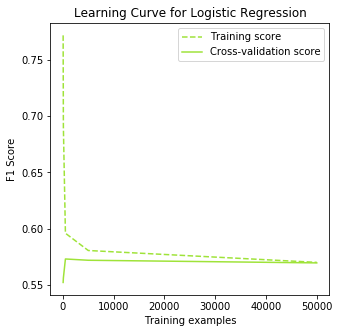

In [85]:
#plot LC for LR
plot_train_curve(logistic_best, "Logistic Regression", train_sizes = [50, 100, 500, 5000, 50000])

The LR best estimator seems to work well with regards to model variance and bias which is evident from the small gap between the two curves. The learning curve also shows that more observations are not necessary as the two lines converge.

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sk

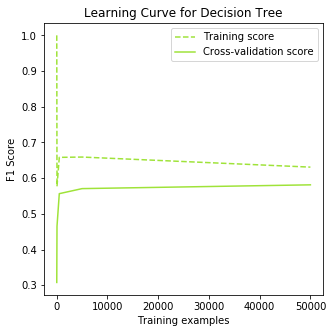

In [86]:
#plt LC for Decision tree
plot_train_curve(tree_best, "Decision Tree", [1, 50, 500, 5000, 50000])

The single tree best estimator does not work so well with regards to model variance and bias. The gap between the two lines is bigger and probably they will converge with more examples at some point. The highest f1 score is again low and possibly reach the best achievable result for this data.

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sk

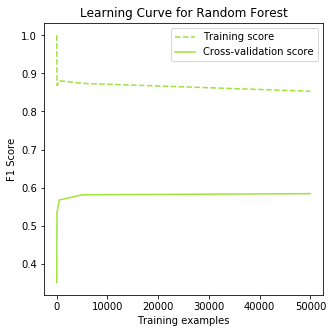

In [87]:
#plot LC for Random Forest
plot_train_curve(forest_best, "Random Forest", [1, 50, 500, 5000, 50000])

It appears that the Random Forest classifier overfits the training data. More observations most probably will not help. Later I am going to try to tune the Random Forest model and to decrease the model variance.

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sk

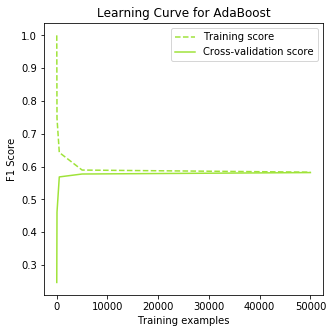

In [88]:
#plot LC for AdaBoost
plot_train_curve(boost_best, "AdaBoost", [1, 50, 500, 5000, 50000])

Here both lines converge early

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no 

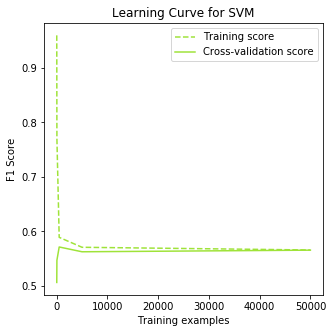

In [89]:
#plot LC for SVM
plot_train_curve(svm_best, "SVM", [20, 50, 500, 5000, 50000])

It looks like the validation score here is decreasing between several and 5000 examples.

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sk

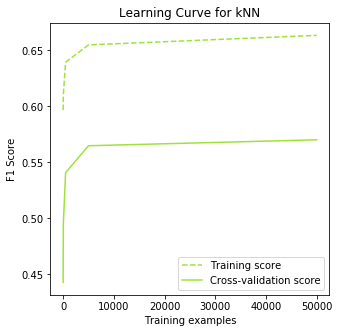

In [90]:
#plot LC for kNN
plot_train_curve(knn_best, "kNN", train_sizes = [12, 50, 500, 5000, 50000])

Here the curve for the training data is flipped which is expected as this algorithm learns better the more data available. According to the learning curve all methods achieve somehow similar results with regards to the F1 score, around 58 %, which result is highly reproducible. This probably means that for the data available there is a high value of the irreducible error. 

###### Apply regularization to the Random Forest model
As the Random Forest model is overfitting the data, I will try to regularize it by setting maximum depth to 6 and minimum samples per leaf also to 6.


In [91]:
forest_reg = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [92]:
forest_reg.fit(cardio_features_train, cardio_target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [93]:
#get the training score to assess variance
forest_reg.score(cardio_features_train, cardio_target_train)

0.6298611364216204

C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\schaubia\Anaconda3\lib\site-packages\sk

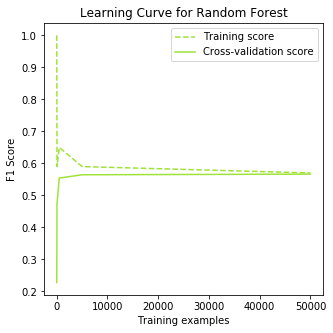

In [94]:
plot_train_curve(forest_reg, "Random Forest", [1, 50, 500, 5000, 50000])

In [95]:
f1_score(cardio_target_test, forest_reg.predict(cardio_features_test), average = "weighted")

0.570507493712888

According to the learning curve, with the tuned hyperparameters, the forest does not overfit the data, however, the scores show some overfitting and also lower performance on the test data in comparison to the prior forest model.

###### Predict my own data

Finally I am going to use the best estimators to predict to which classes are several new observations going to be assigned.

In [103]:
my_data = pd.read_csv("data/my_data.csv")

In [104]:
my_data

,age,gender,height,weight,smoke,alco,active,cardio,cholesterol_above normal,cholesterol_well above normal,gluc_above normal,gluc_well above normal
0,2,1,100,14,0,0,1,0,0,0,0,0
1,9,1,135,42,0,0,1,0,0,0,0,0
2,35,1,169,51,0,0,1,0,0,0,0,0
3,37,0,174,59,1,1,1,0,0,0,0,0
4,63,1,147,48,1,1,0,1,0,0,0,0
5,63,1,165,69,0,1,0,1,1,0,1,0


In [105]:
logistic_best.predict(my_data)

array(['normal', 'normal', 'normal', 'prehypertension', 'prehypertension',
       'prehypertension'], dtype=object)

In [106]:
tree_best.predict(my_data)

array(['prehypertension', 'prehypertension', 'prehypertension',
       'prehypertension', 'hypertension', 'prehypertension'], dtype=object)

In [107]:
forest_best.predict(my_data)

array(['normal', 'normal', 'normal', 'normal', 'prehypertension',
       'prehypertension'], dtype=object)

In [108]:
svm_best.predict(my_data)

array(['normal', 'normal', 'normal', 'prehypertension', 'prehypertension',
       'prehypertension'], dtype=object)

In [109]:
knn_best.predict(my_data)

array(['normal', 'prehypertension', 'normal', 'normal', 'prehypertension',
       'normal'], dtype=object)

From all algorithms, the only the forest predicts the true labels. It seems that convertion to dummy variables makes the corresponding feture less important, may be it will be better for glucose and cholesterol data to be binary - high or normal.

### Discussion and further investigations

Overall the results from all machine learning models that have been trained on both datasets are low, especially for the second dataset; however, this is probably expected and the models have reached the highest scores possible for the available data. There are several particularities in the clinical data that are probably misleading the algorithms including the fact that most blood pressure readings are centered around the normal systolic (120) and diastolic (80) values. Additionally there are several other features that are going to play role on the cardiovascular system condition such as other vital signs (pulse, temperature and respiration rate), the condition of other biological systems (excretory and digestive) measured by liver and kidney enzymes (angiotensin can be especially important), the function of the endocrine system and hormonal blood levels, presence of neurological and psychiatric diseases, anxiety levels and many more. In addition, the blood pressure readings in the current datasets are not the mean values for a certain period of time, but rather are measurements at the moment of medical examination.<br> 

As a part of a further investigation,  a dataset with all these factors included as features will be more adequate and most probably will lead to better performing machine learning models. Unsupervised learning algorithms including K means could also give valuable results as a part of any further work.<br>

With regards to the dataset here, additional investigations may include plotting a validation curve or a learning curve with loss function measurement instead of metrics per number of observations. For the first part of the project principal component analysis may contribute to lowering the computation time of the worse performing (with regards to computational time) methods such as SVMs.

### Conclusion

All models that have been trained and tested on the data available do not reach high enough results which most probably is inherent to these particular datasets. In both parts the chosen on score basis best classificator predicts better for the first class (normal blood pressure) and it can be deduced that it is difficult for the models to distinguish between the clinical data for pre- and hypertensive patients. It may also be concluded from the numbers in the confusion matrices that the model was misled due to accumulation of blood pressure values close to the borderline between normal and abnormal readings. The best classificators recall score which in the case of medical data predictions is very important is low for the classes of interest. ROC curve conveys visual interpretation of the model performance; however, the learning curve with metric measurement which was plotted for all methods in the first part gives more thorough information regarding model variance and the fact that the models reach the best possible for this data results. he overfitting of the Random Forest classifier was successfully addressed by hyperparameter tuning. The second part of the project was unable to show noise in data which can be reduced by PCA. 

### Resources:
1. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0240370
2. https://www.cdc.gov/bloodpressure/about.htm
3. https://www.sciencedirect.com/science/article/abs/pii/S0957417405000758
4. https://www.kaggle.com/kmukhammadjon/hypertension-incidence-in-two-and-half-years
5. https://www.kaggle.com/sulianova/cardiovascular-disease-dataset
6. https://www.kaggle.com/raminhashimzade/cardio-disease
7. https://towardsdatascience.com/introduction-to-data-preprocessing-in-machine-learning-a9fa83a5dc9d
8. https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/
9. https://xavierbourretsicotte.github.io/AdaBoost.html
10. https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/
11. https://medium.com/@mohtedibf/in-depth-parameter-tuning-for-knn-4c0de485baf6
12. https://dev.to/overrideveloper/understanding-the-confusion-matrix-264i
13. https://stackoverflow.com/questions/51378105/plot-multi-class-roc-curve-for-decisiontreeclassifier 
14. https://www.dataquest.io/blog/learning-curves-machine-learning/